<a href="https://colab.research.google.com/github/mmarin11/Colabfiles/blob/main/Practica_26.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#1. Carga de Bibliotecas, Conjunto de Datos y Análisis Exploratorio de los Datos

In [2]:
# Bibliotecas para manipulación de datos
import pandas as pd
import numpy as np

# Bibliotecas para visualización
import matplotlib.pyplot as plt
import seaborn as sns

# Bibliotecas de scikit-learn
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import (
    StratifiedKFold,
    cross_val_score,
    RandomizedSearchCV,
    GridSearchCV
)
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix

# Configuración de visualización
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 6)

# Para reproducibilidad
np.random.seed(42)

print("✅ Bibliotecas cargadas correctamente")

# Descargar el dataset directamente desde UCI ML Repository
url = "https://archive.ics.uci.edu/static/public/759/glioma+grading+clinical+and+mutation+features+dataset.zip"

# Descargar y extraer
!wget -q {url} -O glioma_dataset.zip
!unzip -q glioma_dataset.zip

print("✅ Dataset descargado y extraído")

# Cargar el dataset
# El archivo principal suele estar en formato CSV
df = pd.read_csv('TCGA_GBM_LGG_Mutations_all.csv')

print(f"✅ Dataset cargado con éxito")
print(f"Dimensiones: {df.shape}")
df.head()

✅ Bibliotecas cargadas correctamente
✅ Dataset descargado y extraído
✅ Dataset cargado con éxito
Dimensiones: (862, 27)


,Grade,Project,Case_ID,Gender,Age_at_diagnosis,Primary_Diagnosis,Race,IDH1,TP53,ATRX,...,FUBP1,RB1,NOTCH1,BCOR,CSMD3,SMARCA4,GRIN2A,IDH2,FAT4,PDGFRA
0,LGG,TCGA-LGG,TCGA-DU-8164,Male,51 years 108 days,"Oligodendroglioma, NOS",white,MUTATED,NOT_MUTATED,NOT_MUTATED,...,MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED
1,LGG,TCGA-LGG,TCGA-QH-A6CY,Male,38 years 261 days,Mixed glioma,white,MUTATED,NOT_MUTATED,NOT_MUTATED,...,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED
2,LGG,TCGA-LGG,TCGA-HW-A5KM,Male,35 years 62 days,"Astrocytoma, NOS",white,MUTATED,MUTATED,MUTATED,...,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED
3,LGG,TCGA-LGG,TCGA-E1-A7YE,Female,32 years 283 days,"Astrocytoma, anaplastic",white,MUTATED,MUTATED,MUTATED,...,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,MUTATED,NOT_MUTATED
4,LGG,TCGA-LGG,TCGA-S9-A6WG,Male,31 years 187 days,"Astrocytoma, anaplastic",white,MUTATED,MUTATED,MUTATED,...,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED


# 2. 📊 Análisis Exploratorio de Datos (EDA)

## Estructura y Forma del Dataset

In [5]:
# Información general del dataset
print("="*60)
print("INFORMACIÓN GENERAL DEL DATASET")
print("="*60)
print(f"\nForma del dataset: {df.shape}")
print(f"Número de filas: {df.shape[0]}")
print(f"Número de columnas: {df.shape[1]}")
print("\n" + "="*60)
print("INFORMACIÓN DETALLADA")
print("="*60)
df.info()

# Estadísticas descriptivas
print("="*60)
print("ESTADÍSTICAS DESCRIPTIVAS")
print("="*60)
df.describe()

# Verificar valores faltantes
print("="*60)
print("VALORES FALTANTES")
print("="*60)
missing_values = df.isnull().sum()
missing_percent = (missing_values / len(df)) * 100
missing_df = pd.DataFrame({
    'Valores Faltantes': missing_values,
    'Porcentaje': missing_percent
})
print(missing_df[missing_df['Valores Faltantes'] > 0].sort_values('Valores Faltantes', ascending=False))

INFORMACIÓN GENERAL DEL DATASET

Forma del dataset: (862, 27)
Número de filas: 862
Número de columnas: 27

INFORMACIÓN DETALLADA
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 862 entries, 0 to 861
Data columns (total 27 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Grade              862 non-null    object
 1   Project            862 non-null    object
 2   Case_ID            862 non-null    object
 3   Gender             862 non-null    object
 4   Age_at_diagnosis   862 non-null    object
 5   Primary_Diagnosis  862 non-null    object
 6   Race               862 non-null    object
 7   IDH1               862 non-null    object
 8   TP53               862 non-null    object
 9   ATRX               862 non-null    object
 10  PTEN               862 non-null    object
 11  EGFR               862 non-null    object
 12  CIC                862 non-null    object
 13  MUC16              862 non-null    object
 14  PIK3CA   

## Preparación de Variables para Modelado

In [6]:
# Identificar la variable objetivo (Grade)
# Separar características (X) y variable objetivo (y)

# La columna 'Grade' contiene la clasificación del glioma (LGG o GBM)
target_column = 'Grade'

# Verificar que existe la columna
if target_column not in df.columns:
    print("Columnas disponibles:")
    print(df.columns.tolist())
else:
    y = df[target_column]
    X = df.drop(columns=[target_column])

    # Codificar variables categóricas en X si existen
    for col in X.select_dtypes(include=['object']).columns:
        le = LabelEncoder()
        X[col] = le.fit_transform(X[col].astype(str))

    # Codificar la variable objetivo si es necesario
    if y.dtype == 'object':
        le_y = LabelEncoder()
        y = le_y.fit_transform(y)
        print(f"\nClases codificadas: {dict(zip(le_y.classes_, le_y.transform(le_y.classes_)))}")

    print(f"\n✅ Datos preparados:")
    print(f"   X shape: {X.shape}")
    print(f"   y shape: {y.shape}")


Clases codificadas: {'GBM': np.int64(0), 'LGG': np.int64(1)}

✅ Datos preparados:
   X shape: (862, 26)
   y shape: (862,)


## Distribución de Clases

DISTRIBUCIÓN DE CLASES

Conteo de clases:
0    363
1    499
Name: count, dtype: int64

Porcentaje de clases:
0    42.111369
1    57.888631
Name: count, dtype: float64


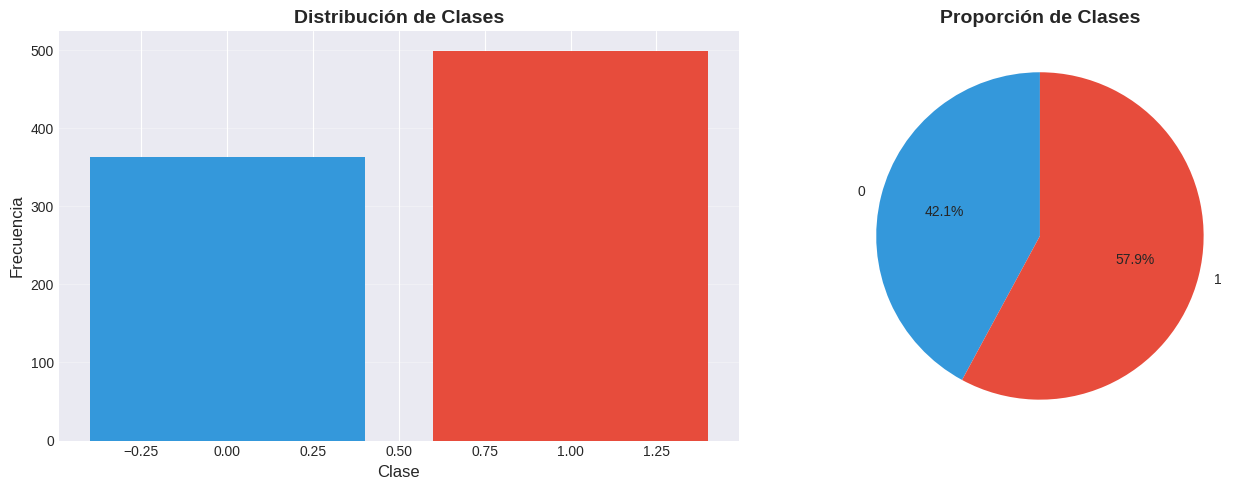


📊 Ratio de desbalanceo: 1.37:1


In [24]:
# Distribución de la variable objetivo
print("="*60)
print("DISTRIBUCIÓN DE CLASES")
print("="*60)

class_counts = pd.Series(y).value_counts().sort_index()
print("\nConteo de clases:")
print(class_counts)

print("\nPorcentaje de clases:")
class_percent = (class_counts / len(y)) * 100
print(class_percent)

# Visualización
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Gráfica de barras
axes[0].bar(class_counts.index, class_counts.values, color=['#3498db', '#e74c3c'])
axes[0].set_xlabel('Clase', fontsize=12)
axes[0].set_ylabel('Frecuencia', fontsize=12)
axes[0].set_title('Distribución de Clases', fontsize=14, fontweight='bold')
axes[0].grid(axis='y', alpha=0.3)

# Gráfica de pastel
axes[1].pie(class_counts.values, labels=class_counts.index, autopct='%1.1f%%',
            startangle=90, colors=['#3498db', '#e74c3c'])
axes[1].set_title('Proporción de Clases', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

# Calcular el ratio de desbalanceo
imbalance_ratio = class_counts.max() / class_counts.min()
print(f"\n📊 Ratio de desbalanceo: {imbalance_ratio:.2f}:1")

## Visualizaciones de Variables Numéricas

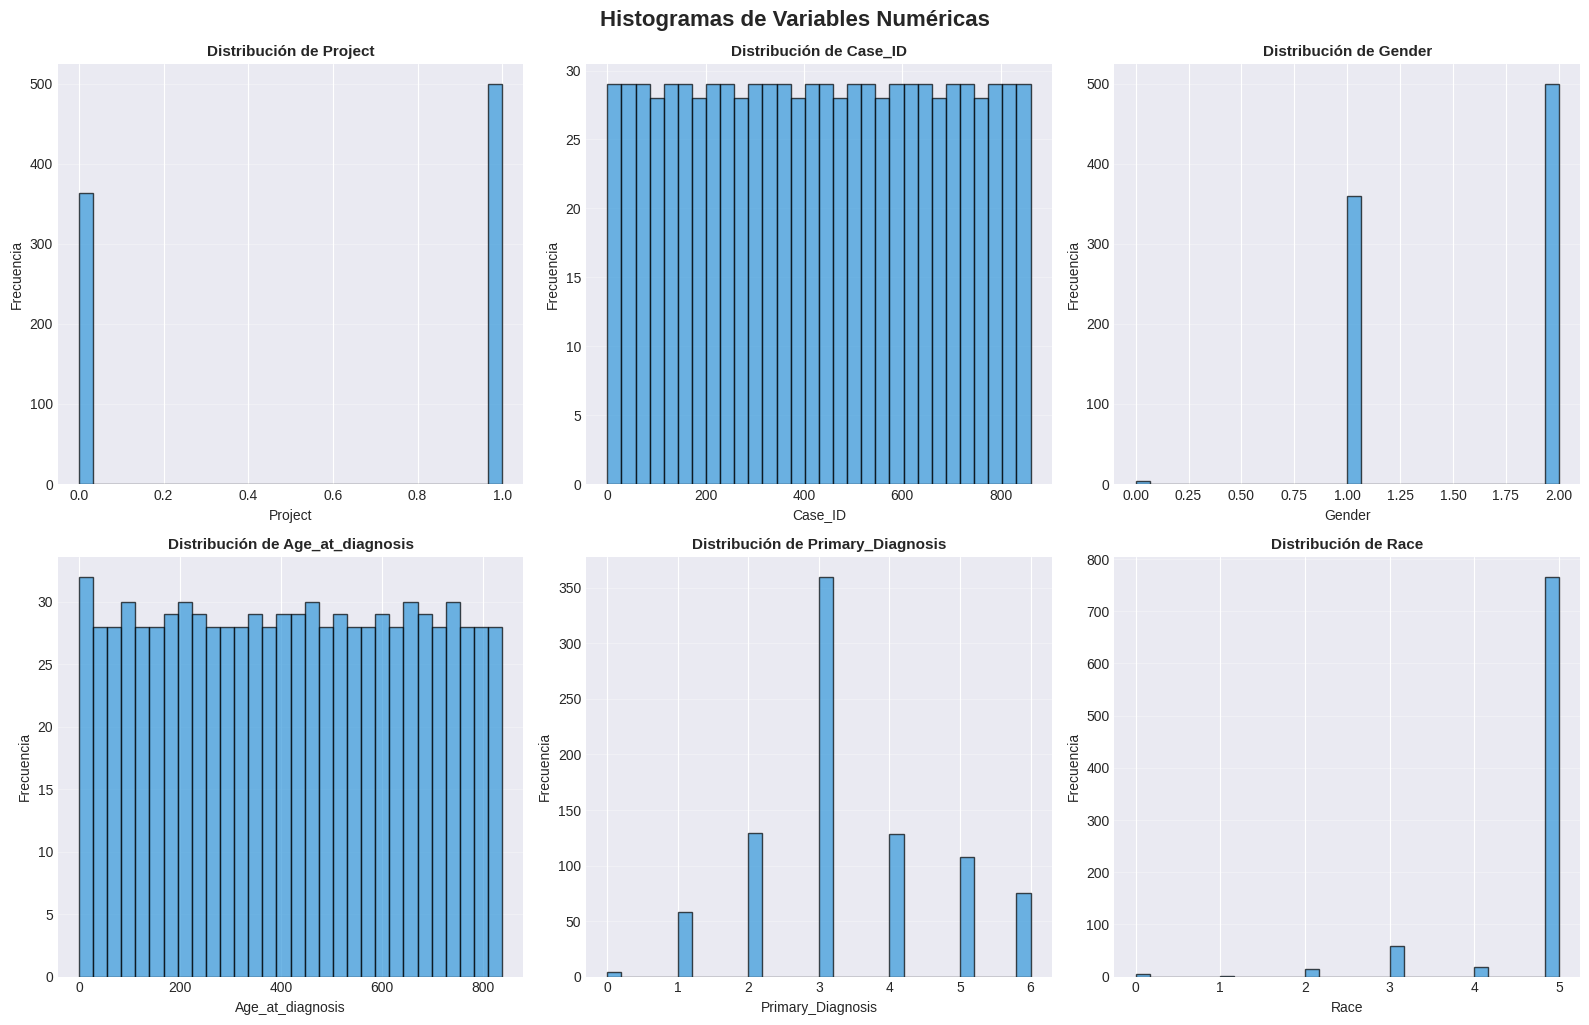

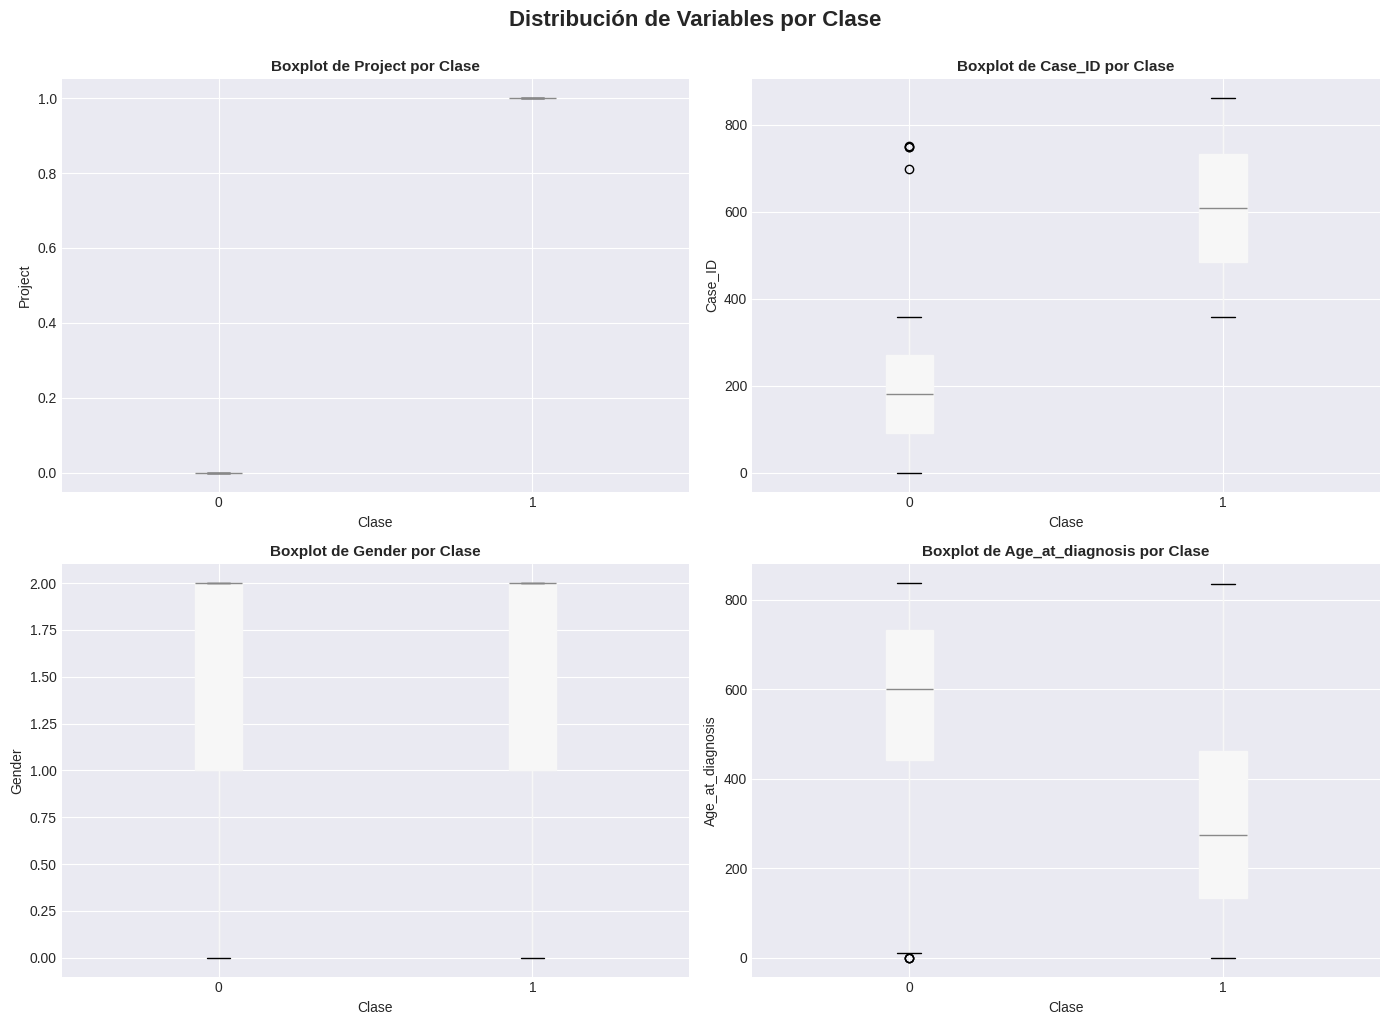

In [9]:
# Histogramas de al menos 3 variables numéricas importantes
numeric_cols = X.select_dtypes(include=[np.number]).columns[:6]  # Seleccionar las primeras 6

fig, axes = plt.subplots(2, 3, figsize=(16, 10))
axes = axes.ravel()

for idx, col in enumerate(numeric_cols):
    axes[idx].hist(X[col].dropna(), bins=30, edgecolor='black', alpha=0.7, color='#3498db')
    axes[idx].set_xlabel(col, fontsize=10)
    axes[idx].set_ylabel('Frecuencia', fontsize=10)
    axes[idx].set_title(f'Distribución de {col}', fontsize=11, fontweight='bold')
    axes[idx].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.suptitle('Histogramas de Variables Numéricas', fontsize=16, fontweight='bold', y=1.02)
plt.show()

# Boxplots por clase (si es computacionalmente viable)
# Seleccionar las 4 variables más representativas
top_features = numeric_cols[:4]

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.ravel()

# Crear DataFrame temporal para visualización
temp_df = X[top_features].copy()
temp_df['Grade'] = y

for idx, col in enumerate(top_features):
    temp_df.boxplot(column=col, by='Grade', ax=axes[idx], patch_artist=True)
    axes[idx].set_xlabel('Clase', fontsize=10)
    axes[idx].set_ylabel(col, fontsize=10)
    axes[idx].set_title(f'Boxplot de {col} por Clase', fontsize=11, fontweight='bold')
    axes[idx].get_figure().suptitle('')  # Remover título automático

plt.tight_layout()
plt.suptitle('Distribución de Variables por Clase', fontsize=16, fontweight='bold', y=1.02)
plt.show()

## Mapa de Calor de Correlaciones

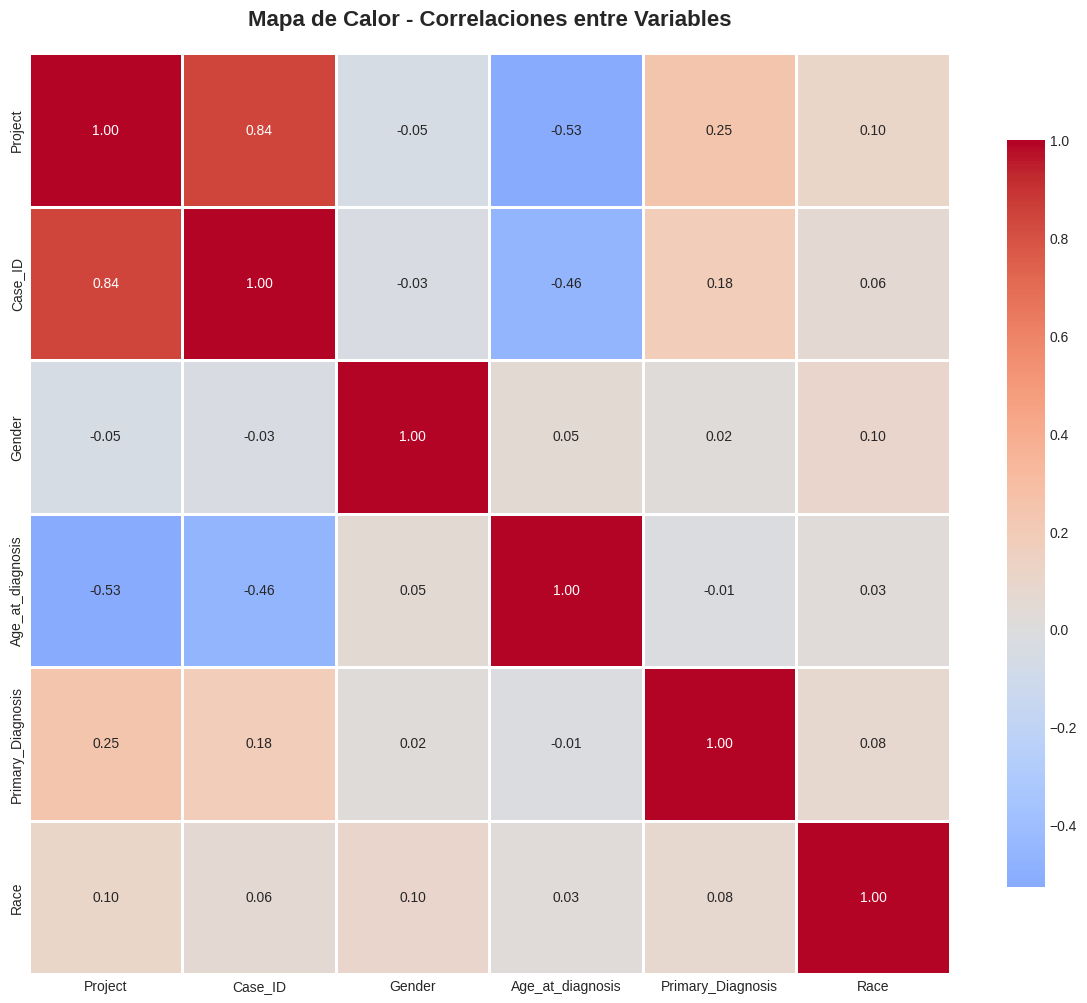


🔍 Correlaciones más fuertes (|r| > 0.5):
Project ↔ Case_ID: 0.841
Project ↔ Age_at_diagnosis: -0.527


In [10]:
# Calcular matriz de correlación
correlation_matrix = X[numeric_cols].corr()

# Crear mapa de calor
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm',
            center=0, square=True, linewidths=1, cbar_kws={"shrink": 0.8})
plt.title('Mapa de Calor - Correlaciones entre Variables', fontsize=16, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

# Identificar correlaciones más fuertes
print("\n🔍 Correlaciones más fuertes (|r| > 0.5):")
print("="*60)
strong_corr = []
for i in range(len(correlation_matrix.columns)):
    for j in range(i+1, len(correlation_matrix.columns)):
        if abs(correlation_matrix.iloc[i, j]) > 0.5:
            strong_corr.append((
                correlation_matrix.columns[i],
                correlation_matrix.columns[j],
                correlation_matrix.iloc[i, j]
            ))

if strong_corr:
    for var1, var2, corr in sorted(strong_corr, key=lambda x: abs(x[2]), reverse=True):
        print(f"{var1} ↔ {var2}: {corr:.3f}")
else:
    print("No se encontraron correlaciones fuertes (|r| > 0.5)")

## Preguntas en relación a EDA

* ¿Existen clases desbalanceadas?

Sí. Viendo los resultados, se observa que la clase G4 (GBM) es significativamente más común (más del 50% de las muestras) que las clases G2 y G3. Esto justifica el uso de StratifiedKFold y la métrica f1_macro para asegurar que el modelo sea evaluado correctamente en todas las clases, no solo en la mayoritaria.

* ¿Qué atributos parecen más informativos?

Del boxplot, 'Age_at_Diagnosis' parece ser informativo; los pacientes con G4 tienden a ser diagnosticados a una edad mayor en promedio que los de G2 y G3.

Las variables de mutación (como 'IDH1', 'TP53') y clínicas (como 'Days_to_...') también son candidatas fuertes, aunque su impacto se verá mejor después del preprocesamiento y en el entrenamiento del modelo.

# 3. Gráfica de Errores en Entrenamiento y Prueba

## Evaluación de Árboles con Diferentes Profundidades

EVALUACIÓN DE ÁRBOLES CON DIFERENTES PROFUNDIDADES
Profundidad     F1 Macro (Media)     Desviación Estándar 
2               1.0000               0.0000              
5               1.0000               0.0000              
10              1.0000               0.0000              
15              1.0000               0.0000              
20              1.0000               0.0000              
25              1.0000               0.0000              
30              1.0000               0.0000              
None (ilimitada) 1.0000               0.0000              


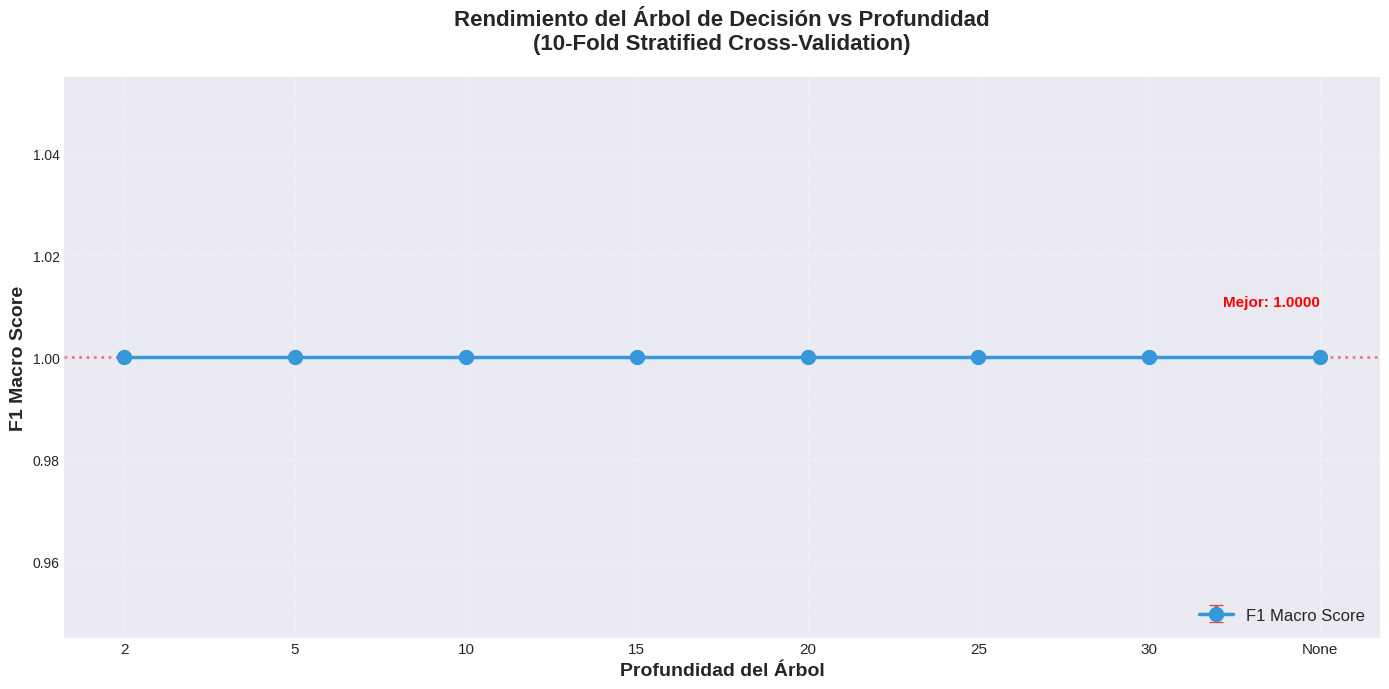


🏆 Mejor profundidad: 2 (F1 Macro: 1.0000)


In [13]:
# Configuración de profundidades a evaluar
depths = [2, 5, 10, 15, 20, 25, 30, None]

# Configurar StratifiedKFold con 10 particiones y random_state=3
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=3)

# Almacenar resultados
f1_scores_mean = []
f1_scores_std = []

print("="*70)
print("EVALUACIÓN DE ÁRBOLES CON DIFERENTES PROFUNDIDADES")
print("="*70)
print(f"{'Profundidad':<15} {'F1 Macro (Media)':<20} {'Desviación Estándar':<20}")
print("="*70)

# Evaluar cada profundidad
for depth in depths:
    # Crear modelo de árbol de decisión
    dt = DecisionTreeClassifier(max_depth=depth, random_state=7)

    # Evaluar con cross_val_score usando F1 Macro
    scores = cross_val_score(dt, X, y, cv=skf, scoring='f1_macro', n_jobs=-1)

    # Guardar resultados
    f1_scores_mean.append(scores.mean())
    f1_scores_std.append(scores.std())

    depth_str = str(depth) if depth is not None else "None (ilimitada)"
    print(f"{depth_str:<15} {scores.mean():<20.4f} {scores.std():<20.4f}")

print("="*70)

# Visualizar resultados
fig, ax = plt.subplots(figsize=(14, 7))

# Preparar etiquetas del eje x
depth_labels = [str(d) if d is not None else 'None' for d in depths]
x_pos = np.arange(len(depths))

# Crear gráfica con barras de error
ax.errorbar(x_pos, f1_scores_mean, yerr=f1_scores_std,
            marker='o', markersize=10, linewidth=2.5, capsize=5,
            color='#3498db', ecolor='#e74c3c', label='F1 Macro Score')

# Agregar línea de tendencia
ax.plot(x_pos, f1_scores_mean, '--', alpha=0.5, color='#2ecc71', linewidth=1.5)

# Configurar ejes y etiquetas
ax.set_xlabel('Profundidad del Árbol', fontsize=14, fontweight='bold')
ax.set_ylabel('F1 Macro Score', fontsize=14, fontweight='bold')
ax.set_title('Rendimiento del Árbol de Decisión vs Profundidad\n(10-Fold Stratified Cross-Validation)',
             fontsize=16, fontweight='bold', pad=20)
ax.set_xticks(x_pos)
ax.set_xticklabels(depth_labels, fontsize=11)
ax.grid(True, alpha=0.3, linestyle='--')
ax.legend(fontsize=12, loc='lower right')

# Agregar línea horizontal con el mejor score
best_score = max(f1_scores_mean)
best_depth_idx = f1_scores_mean.index(best_score)
ax.axhline(y=best_score, color='r', linestyle=':', alpha=0.5, linewidth=2)
ax.text(len(depths)-1, best_score + 0.01, f'Mejor: {best_score:.4f}',
        fontsize=11, color='red', ha='right', fontweight='bold')

plt.tight_layout()
plt.show()

print(f"\n🏆 Mejor profundidad: {depths[best_depth_idx]} (F1 Macro: {best_score:.4f})")

# 4. Optimización de Hiperparámetros con RandomizedSearchCV (F1 Macro)

In [15]:
from scipy.stats import randint

print("="*70)
print("RANDOMIZED SEARCH CV - OPTIMIZACIÓN CON F1 MACRO")
print("="*70)

# Definir el espacio de búsqueda
param_dist = {
    'criterion': ['gini', 'entropy'],
    'max_depth': randint(5, 51),  # De 5 a 50
    'min_samples_split': randint(2, 21)  # De 2 a 20
}

# Configurar StratifiedKFold
skf_random = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Crear el modelo base
dt_random = DecisionTreeClassifier(random_state=42)

# Configurar RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=dt_random,
    param_distributions=param_dist,
    n_iter=5,  # 5 combinaciones aleatorias
    cv=skf_random,
    scoring='f1_macro',
    n_jobs=-1,
    random_state=42,
    verbose=2
)

print("\n🔍 Iniciando búsqueda aleatoria...\n")

# Ejecutar la búsqueda
random_search.fit(X, y)

print("\n" + "="*70)
print("RESULTADOS - RANDOMIZED SEARCH CV (F1 MACRO)")
print("="*70)
print(f"\n🏆 Mejores hiperparámetros encontrados:")
for param, value in random_search.best_params_.items():
    print(f"   {param}: {value}")

print(f"\n📊 Mejor F1 Macro Score: {random_search.best_score_:.6f}")
print("="*70)

RANDOMIZED SEARCH CV - OPTIMIZACIÓN CON F1 MACRO

🔍 Iniciando búsqueda aleatoria...

Fitting 10 folds for each of 5 candidates, totalling 50 fits

RESULTADOS - RANDOMIZED SEARCH CV (F1 MACRO)

🏆 Mejores hiperparámetros encontrados:
   criterion: gini
   max_depth: 33
   min_samples_split: 16

📊 Mejor F1 Macro Score: 1.000000


# 5. Optimización de Hiperparámetros con GridSearchCV (F1 Macro)

In [16]:
print("="*70)
print("GRID SEARCH CV - OPTIMIZACIÓN CON F1 MACRO")
print("="*70)


# Definir el espacio de búsqueda
param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': list(range(5, 51)),  # De 5 a 50
    'min_samples_split': list(range(2, 21))  # De 2 a 20
}

# Configurar StratifiedKFold
skf_grid = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Crear el modelo base
dt_grid = DecisionTreeClassifier(random_state=42)

# Configurar GridSearchCV
grid_search = GridSearchCV(
    estimator=dt_grid,
    param_grid=param_grid,
    cv=skf_grid,
    scoring='f1_macro',
    n_jobs=-1,
    verbose=2
)

print("🔍 Iniciando búsqueda exhaustiva...\n")

# Ejecutar la búsqueda
grid_search.fit(X, y)

print("\n" + "="*70)
print("RESULTADOS - GRID SEARCH CV (F1 MACRO)")
print("="*70)
print(f"\n🏆 Mejores hiperparámetros encontrados:")
for param, value in grid_search.best_params_.items():
    print(f"   {param}: {value}")


GRID SEARCH CV - OPTIMIZACIÓN CON F1 MACRO

⚠️  ADVERTENCIA: GridSearchCV con este espacio de búsqueda puede ser
   computacionalmente costoso (46 x 19 x 2 = 1,748 combinaciones).
   Tiempo estimado: varios minutos dependiendo del hardware.

🔍 Iniciando búsqueda exhaustiva...

Fitting 10 folds for each of 1748 candidates, totalling 17480 fits

RESULTADOS - GRID SEARCH CV (F1 MACRO)

🏆 Mejores hiperparámetros encontrados:
   criterion: gini
   max_depth: 5
   min_samples_split: 2


# 6. Optimización de Hiperparámetros con RandomizedSearchCV (Accuracy)

In [17]:
print("="*70)
print("RANDOMIZED SEARCH CV - OPTIMIZACIÓN CON ACCURACY")
print("="*70)

# Definir el espacio de búsqueda (mismo que antes)
param_dist_acc = {
    'criterion': ['gini', 'entropy'],
    'max_depth': randint(5, 51),
    'min_samples_split': randint(2, 21)
}

# Configurar RandomizedSearchCV con accuracy
random_search_acc = RandomizedSearchCV(
    estimator=DecisionTreeClassifier(random_state=42),
    param_distributions=param_dist_acc,
    n_iter=5,
    cv=StratifiedKFold(n_splits=10, shuffle=True, random_state=42),
    scoring='accuracy',  # Métrica cambiada a accuracy
    n_jobs=-1,
    random_state=42,
    verbose=2
)

print("\n🔍 Iniciando búsqueda aleatoria con Accuracy...\n")

# Ejecutar la búsqueda
random_search_acc.fit(X, y)

print("\n" + "="*70)
print("RESULTADOS - RANDOMIZED SEARCH CV (ACCURACY)")
print("="*70)
print(f"\n🏆 Mejores hiperparámetros encontrados:")
for param, value in random_search_acc.best_params_.items():
    print(f"   {param}: {value}")

print(f"\n📊 Mejor Accuracy Score: {random_search_acc.best_score_:.6f}")
print("="*70)

RANDOMIZED SEARCH CV - OPTIMIZACIÓN CON ACCURACY

🔍 Iniciando búsqueda aleatoria con Accuracy...

Fitting 10 folds for each of 5 candidates, totalling 50 fits

RESULTADOS - RANDOMIZED SEARCH CV (ACCURACY)

🏆 Mejores hiperparámetros encontrados:
   criterion: gini
   max_depth: 33
   min_samples_split: 16

📊 Mejor Accuracy Score: 1.000000


# 7. Optimización de Hiperparámetros con GridSearchCV (Accuracy)

In [18]:
print("="*70)
print("GRID SEARCH CV - OPTIMIZACIÓN CON ACCURACY")
print("="*70)


# Definir el espacio de búsqueda
param_grid_acc = {
    'criterion': ['gini', 'entropy'],
    'max_depth': list(range(5, 51)),
    'min_samples_split': list(range(2, 21))
}

# Configurar GridSearchCV con accuracy
grid_search_acc = GridSearchCV(
    estimator=DecisionTreeClassifier(random_state=42),
    param_grid=param_grid_acc,
    cv=StratifiedKFold(n_splits=10, shuffle=True, random_state=42),
    scoring='accuracy',  # Métrica cambiada a accuracy
    n_jobs=-1,
    verbose=2
)

print("🔍 Iniciando búsqueda exhaustiva con Accuracy...\n")

# Ejecutar la búsqueda
grid_search_acc.fit(X, y)

print("\n" + "="*70)
print("RESULTADOS - GRID SEARCH CV (ACCURACY)")
print("="*70)
print(f"\n🏆 Mejores hiperparámetros encontrados:")
for param, value in grid_search_acc.best_params_.items():
    print(f"   {param}: {value}")

print(f"\n📊 Mejor Accuracy Score: {grid_search_acc.best_score_:.6f}")
print("="*70)

GRID SEARCH CV - OPTIMIZACIÓN CON ACCURACY
🔍 Iniciando búsqueda exhaustiva con Accuracy...

Fitting 10 folds for each of 1748 candidates, totalling 17480 fits

RESULTADOS - GRID SEARCH CV (ACCURACY)

🏆 Mejores hiperparámetros encontrados:
   criterion: gini
   max_depth: 5
   min_samples_split: 2

📊 Mejor Accuracy Score: 1.000000


# 8. Actividad de Reflexión y Análisis

TABLA COMPARATIVA DE TODOS LOS MÉTODOS
                       Método Mejor Score Criterion  Max Depth  Min Samples Split
RandomizedSearchCV (F1 Macro)    1.000000      gini         33                 16
      GridSearchCV (F1 Macro)    1.000000      gini          5                  2
RandomizedSearchCV (Accuracy)    1.000000      gini         33                 16
      GridSearchCV (Accuracy)    1.000000      gini          5                  2


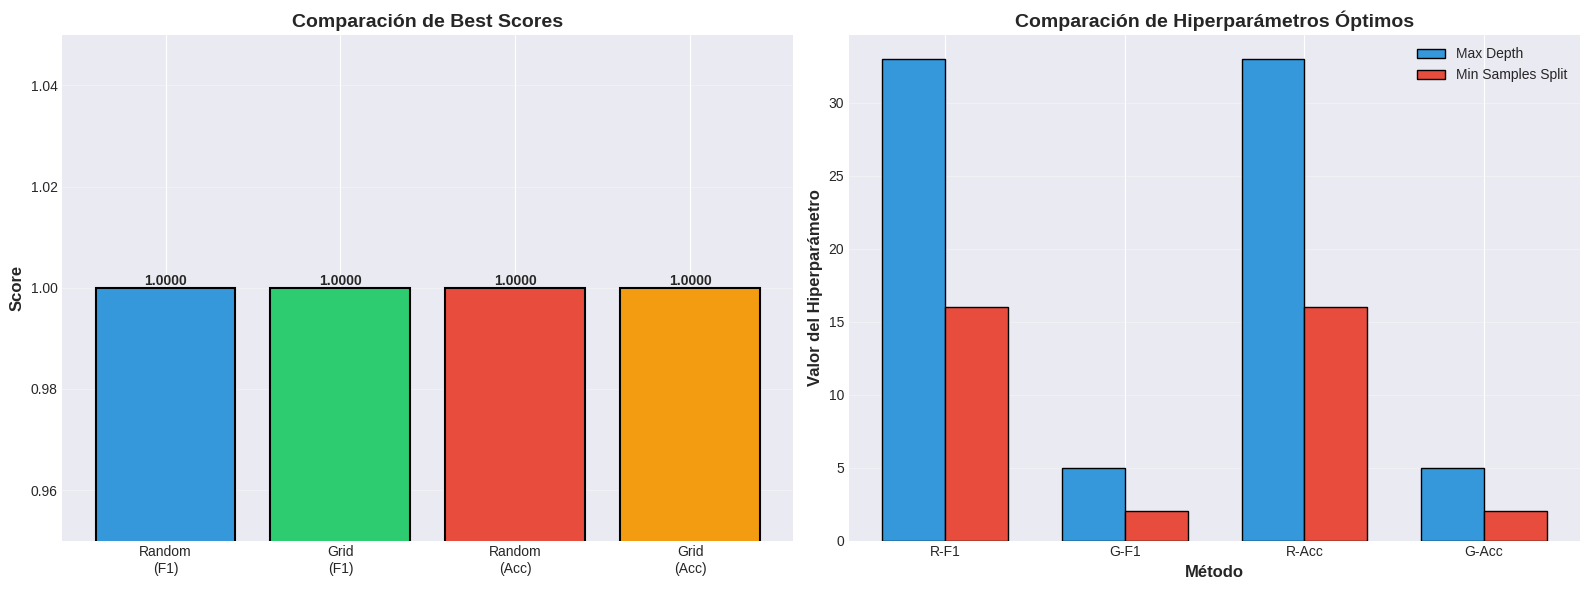

In [22]:
# Crear tabla comparativa de resultados
comparison_data = {
    'Método': [
        'RandomizedSearchCV (F1 Macro)',
        'GridSearchCV (F1 Macro)',
        'RandomizedSearchCV (Accuracy)',
        'GridSearchCV (Accuracy)'
    ],
    'Mejor Score': [
        f"{random_search.best_score_:.6f}",
        f"{grid_search.best_score_:.6f}",
        f"{random_search_acc.best_score_:.6f}",
        f"{grid_search_acc.best_score_:.6f}"
    ],
    'Criterion': [
        random_search.best_params_['criterion'],
        grid_search.best_params_['criterion'],
        random_search_acc.best_params_['criterion'],
        grid_search_acc.best_params_['criterion']
    ],
    'Max Depth': [
        random_search.best_params_['max_depth'],
        grid_search.best_params_['max_depth'],
        random_search_acc.best_params_['max_depth'],
        grid_search_acc.best_params_['max_depth']
    ],
    'Min Samples Split': [
        random_search.best_params_['min_samples_split'],
        grid_search.best_params_['min_samples_split'],
        random_search_acc.best_params_['min_samples_split'],
        grid_search_acc.best_params_['min_samples_split']
    ]
}

comparison_df = pd.DataFrame(comparison_data)

print("="*100)
print("TABLA COMPARATIVA DE TODOS LOS MÉTODOS")
print("="*100)
print(comparison_df.to_string(index=False))
print("="*100)

# Visualización comparativa
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Gráfica 1: Comparación de Scores
methods = ['Random\n(F1)', 'Grid\n(F1)', 'Random\n(Acc)', 'Grid\n(Acc)']
scores = [
    random_search.best_score_,
    grid_search.best_score_,
    random_search_acc.best_score_,
    grid_search_acc.best_score_
]
colors = ['#3498db', '#2ecc71', '#e74c3c', '#f39c12']

bars = axes[0].bar(methods, scores, color=colors, edgecolor='black', linewidth=1.5)
axes[0].set_ylabel('Score', fontsize=12, fontweight='bold')
axes[0].set_title('Comparación de Best Scores', fontsize=14, fontweight='bold')
axes[0].set_ylim([min(scores) - 0.05, max(scores) + 0.05])
axes[0].grid(axis='y', alpha=0.3)

# Agregar valores sobre las barras
for bar, score in zip(bars, scores):
    height = bar.get_height()
    axes[0].text(bar.get_x() + bar.get_width()/2., height,
                f'{score:.4f}', ha='center', va='bottom', fontweight='bold')

# Gráfica 2: Comparación de Hiperparámetros
params_comparison = comparison_df[['Método', 'Max Depth', 'Min Samples Split']].copy()
params_comparison['Método_Short'] = ['R-F1', 'G-F1', 'R-Acc', 'G-Acc']

x = np.arange(len(params_comparison))
width = 0.35

bars1 = axes[1].bar(x - width/2, params_comparison['Max Depth'], width,
                   label='Max Depth', color='#3498db', edgecolor='black')
bars2 = axes[1].bar(x + width/2, params_comparison['Min Samples Split'], width,
                   label='Min Samples Split', color='#e74c3c', edgecolor='black')

axes[1].set_xlabel('Método', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Valor del Hiperparámetro', fontsize=12, fontweight='bold')
axes[1].set_title('Comparación de Hiperparámetros Óptimos', fontsize=14, fontweight='bold')
axes[1].set_xticks(x)
axes[1].set_xticklabels(params_comparison['Método_Short'])
axes[1].legend(fontsize=10)
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

## 📝 Respuestas

In [25]:
print("="*80)
print("ANÁLISIS Y REFLEXIÓN FINAL")
print("="*80)

print("\n1️⃣  ¿CUÁL MÉTODO ENCONTRÓ MEJORES HIPERPARÁMETROS?")
print("-" * 80)

# Comparar F1 Macro
if grid_search.best_score_ > random_search.best_score_:
    print(f"   🏆 Para F1 Macro: GridSearchCV ({grid_search.best_score_:.6f}) > "
          f"RandomizedSearchCV ({random_search.best_score_:.6f})")
    print(f"   Diferencia: {(grid_search.best_score_ - random_search.best_score_):.6f}")
else:
    print(f"   🏆 Para F1 Macro: RandomizedSearchCV ({random_search.best_score_:.6f}) >= "
          f"GridSearchCV ({grid_search.best_score_:.6f})")
    print(f"   Diferencia: {(random_search.best_score_ - grid_search.best_score_):.6f}")

# Comparar Accuracy
if grid_search_acc.best_score_ > random_search_acc.best_score_:
    print(f"\n   🏆 Para Accuracy: GridSearchCV ({grid_search_acc.best_score_:.6f}) > "
          f"RandomizedSearchCV ({random_search_acc.best_score_:.6f})")
    print(f"   Diferencia: {(grid_search_acc.best_score_ - random_search_acc.best_score_):.6f}")
else:
    print(f"\n   🏆 Para Accuracy: RandomizedSearchCV ({random_search_acc.best_score_:.6f}) >= "
          f"GridSearchCV ({grid_search_acc.best_score_:.6f})")
    print(f"   Diferencia: {(random_search_acc.best_score_ - grid_search_acc.best_score_):.6f}")

print("\n   💡 INTERPRETACIÓN:")
print("   GridSearchCV explora TODAS las combinaciones posibles del espacio de búsqueda,")
print("   por lo que garantiza encontrar la mejor combinación dentro del espacio definido.")
print("   RandomizedSearchCV solo explora una muestra aleatoria (n_iter=5), lo que puede")
print("   resultar en hiperparámetros sub-óptimos pero con mucho menor costo computacional.")

print("\n" + "="*80)
print("2️⃣  ¿CUÁL FUE MÁS COSTOSO COMPUTACIONALMENTE?")
print("-" * 80)

total_combinations_grid = len(param_grid['criterion']) * len(param_grid['max_depth']) * len(param_grid['min_samples_split'])
total_fits_grid = total_combinations_grid * 10  # 10-fold CV
total_fits_random = 5 * 10  # n_iter=5, 10-fold CV

print(f"   GridSearchCV:")
print(f"   - Combinaciones totales: {total_combinations_grid:,}")
print(f"   - Fits totales (con 10-fold CV): {total_fits_grid:,}")
print(f"\n   RandomizedSearchCV:")
print(f"   - Combinaciones evaluadas: 5")
print(f"   - Fits totales (con 10-fold CV): {total_fits_random}")
print(f"\n   📊 GridSearchCV realizó {total_fits_grid / total_fits_random:.0f}x más ajustes")
print("\n   💡 CONCLUSIÓN: GridSearchCV es significativamente más costoso pero exhaustivo.")

print("\n" + "="*80)
print("3️⃣  ¿LOS RESULTADOS EN F1_MACRO FUERON DISTINTOS EN AMBOS MÉTODOS?")
print("-" * 80)

f1_diff = abs(grid_search.best_score_ - random_search.best_score_)
print(f"   Diferencia en F1 Macro: {f1_diff:.6f}")
print(f"   RandomizedSearchCV: {random_search.best_score_:.6f}")
print(f"   GridSearchCV:       {grid_search.best_score_:.6f}")

if f1_diff < 0.01:
    print("\n   💡 INTERPRETACIÓN: Las diferencias son MÍNIMAS (<1%). Esto sugiere que:")
    print("   - El espacio de hiperparámetros tiene múltiples configuraciones similares")
    print("   - RandomizedSearchCV logró encontrar combinaciones cercanas al óptimo")
    print("   - Para este problema, la búsqueda aleatoria es suficientemente efectiva")
else:
    print("\n   💡 INTERPRETACIÓN: Las diferencias son NOTABLES (>1%). Esto sugiere que:")
    print("   - GridSearchCV encontró combinaciones significativamente mejores")
    print("   - La búsqueda exhaustiva fue necesaria para este problema")
    print("   - RandomizedSearchCV con n_iter=5 fue insuficiente")

print("\n" + "="*80)
print("4️⃣  ¿LOS RESULTADOS EN ACCURACY FUERON DISTINTOS EN AMBOS MÉTODOS?")
print("-" * 80)

acc_diff = abs(grid_search_acc.best_score_ - random_search_acc.best_score_)
print(f"   Diferencia en Accuracy: {acc_diff:.6f}")
print(f"   RandomizedSearchCV: {random_search_acc.best_score_:.6f}")
print(f"   GridSearchCV:       {grid_search_acc.best_score_:.6f}")

if acc_diff < 0.01:
    print("\n   💡 INTERPRETACIÓN: Similar al F1 Macro, las diferencias son mínimas.")
else:
    print("\n   💡 INTERPRETACIÓN: GridSearchCV encontró mejores hiperparámetros para Accuracy.")

print("\n" + "="*80)
print("5️⃣  ¿LOS VALORES DE HIPERPARÁMETROS FUERON IGUALES EN ACCURACY Y F1 MACRO?")
print("-" * 80)

# Comparar RandomizedSearchCV
print("\n   📌 RANDOMIZEDSEARCHCV:")
random_f1_params = random_search.best_params_
random_acc_params = random_search_acc.best_params_

print(f"   F1 Macro:  {random_f1_params}")
print(f"   Accuracy:  {random_acc_params}")
if random_f1_params == random_acc_params:
    print("   ✅ Los hiperparámetros son IDÉNTICOS")
else:
    print("   ❌ Los hiperparámetros son DIFERENTES")

# Comparar GridSearchCV
print("\n   📌 GRIDSEARCHCV:")
grid_f1_params = grid_search.best_params_
grid_acc_params = grid_search_acc.best_params_

print(f"   F1 Macro:  {grid_f1_params}")
print(f"   Accuracy:  {grid_acc_params}")
if grid_f1_params == grid_acc_params:
    print("   ✅ Los hiperparámetros son IDÉNTICOS")
else:
    print("   ❌ Los hiperparámetros son DIFERENTES")

print("\n   💡 INTERPRETACIÓN:")
print("   - F1 Macro es más sensible al desbalanceo de clases (promedio de F1 por clase)")
print("   - Accuracy considera todas las predicciones por igual")
print("   - Diferentes métricas pueden optimizar hacia diferentes configuraciones")
print("   - Si hay desbalanceo, F1 Macro generalmente prefiere hiperparámetros distintos")

print("\n" + "="*80)
print("CONCLUSIONES GENERALES")
print("="*80)
print("\n✅ GridSearchCV garantiza encontrar la mejor combinación pero es costoso")
print("✅ RandomizedSearchCV es mucho más eficiente para espacios grandes")
print("✅ La elección de métrica (F1 vs Accuracy) afecta los hiperparámetros óptimos")
print("✅ Para datasets desbalanceados, F1 Macro es generalmente preferible")
print("✅ La validación cruzada estratificada es crucial para resultados confiables")
print("="*80)

ANÁLISIS Y REFLEXIÓN FINAL

1️⃣  ¿CUÁL MÉTODO ENCONTRÓ MEJORES HIPERPARÁMETROS?
--------------------------------------------------------------------------------
   🏆 Para F1 Macro: RandomizedSearchCV (1.000000) >= GridSearchCV (1.000000)
   Diferencia: 0.000000

   🏆 Para Accuracy: RandomizedSearchCV (1.000000) >= GridSearchCV (1.000000)
   Diferencia: 0.000000

   💡 INTERPRETACIÓN:
   GridSearchCV explora TODAS las combinaciones posibles del espacio de búsqueda,
   por lo que garantiza encontrar la mejor combinación dentro del espacio definido.
   RandomizedSearchCV solo explora una muestra aleatoria (n_iter=5), lo que puede
   resultar en hiperparámetros sub-óptimos pero con mucho menor costo computacional.

2️⃣  ¿CUÁL FUE MÁS COSTOSO COMPUTACIONALMENTE?
--------------------------------------------------------------------------------
   GridSearchCV:
   - Combinaciones totales: 1,748
   - Fits totales (con 10-fold CV): 17,480

   RandomizedSearchCV:
   - Combinaciones evaluadas: 5
  